# Loading Data-Set


In [4]:
from datasets import load_dataset
import random
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
import re


dataset = load_dataset('race', 'all', split='train')
print("Sample of dataset:", dataset[0])


Sample of dataset: {'example_id': 'high19088.txt', 'article': 'Last week I talked with some of my students about what they wanted to do after they graduated, and what kind of job prospects  they thought they had.\nGiven that I teach students who are training to be doctors, I was surprised do find that most thought that they would not be able to get the jobs they wanted without "outside help". "What kind of help is that?" I asked, expecting them to tell me that they would need a   or family friend to help them out.\n"Surgery ," one replied.\nI was pretty alarmed by that response. It seems that the graduates of today are increasingly willing to go under the knife to get ahead of others when it comes to getting a job .\nOne girl told me that she was considering surgery to increase her height. "They break your legs, put in special extending screws, and slowly expand the gap between the two ends of the bone as it re-grows, you can get at least 5 cm taller!"\nAt that point, I was shocked. I 

# Pre-Processing

In [5]:
def create_fill_in_the_blank(dataset, remove_word_pos=0.75):
    processed_data = []
    for example in dataset:
        article = example['article']
        sentences = article.split('. ')
        for sentence in sentences:
            # Remove extra punctuation for clarity
            sentence = re.sub(r'[^\w\s]', '', sentence)

            words = sentence.split()
            if len(words) < 4:
                continue  # Skip short sentences

            # Calculate index for the word to be blanked out
            start_index = int(len(words) * remove_word_pos)
            end_index = len(words) - 2  # Exclude the last word

            # Skip if there are no words to remove in the latter half
            if start_index >= end_index:
                continue

            # Choose a word to remove from the latter half
            blank_index = random.randint(start_index, end_index)
            missing_word = words[blank_index]

            part_a = ' '.join(words[:blank_index]).strip()
            part_b = ' '.join(reversed(words[blank_index + 1:])).strip()
            processed_data.append({
                'Part A': part_a,
                'Part B': part_b,
                'Missing Word': missing_word
            })

    return processed_data


processed_data = create_fill_in_the_blank(dataset)

In [6]:
for i in range(5):
    print("Part A:", processed_data[i]['Part A'])
    print("Part B:", processed_data[i]['Part B'])
    print("Missing Word:", processed_data[i]['Missing Word'])
    print()

Part A: Last week I talked with some of my students about what they wanted to do after they graduated and what kind of job prospects they thought they had Given that I teach students who are training to be doctors I was surprised do find that most thought that they would not be able to get the jobs they wanted without
Part B: help
Missing Word: outside

Part A: What kind of help is that I asked expecting them to tell me that they would need a or family friend to help them out Surgery one replied I was
Part B: response that by alarmed
Missing Word: pretty

Part A: It seems that the graduates of today are increasingly willing to go under the knife to get ahead of others when it comes to getting a job One girl told me that she was considering surgery to
Part B: height her
Missing Word: increase

Part A: They break your legs put in special extending screws and slowly expand the gap between the two ends of the bone as it regrows you can get at
Part B: shocked was I point that At taller cm 5

# LSTM Network Design & Model Implementation

In [8]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
vocab_size = tokenizer.vocab_size

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()

        # Shared embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM layer for processing sequence data
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, batch_first=True)

        # Output layer that predicts within the vocabulary set
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        output = self.fc(lstm_out[:, -1, :])
        return output

# Define the model parameters
embedding_dim = 128
hidden_dim = 256
output_dim = vocab_size  # Output size should match vocabulary size

# Instantiate Forward and Backward LSTM models
forward_lstm_model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim).to(device)
backward_lstm_model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(forward_lstm_model.parameters()) + list(backward_lstm_model.parameters()), lr=0.001)

# Tokenize the input sequences (Part A and Part B)
def tokenize_input(text, tokenizer, max_len=50):
    tokens = tokenizer(text, padding='max_length', max_length=max_len, truncation=True, return_tensors='pt')
    return tokens.input_ids.squeeze(0).to(device)

sample_part_a = processed_data[0]['Part A']
sample_part_b = processed_data[0]['Part B']


sample_part_a_ids = tokenize_input(sample_part_a, tokenizer)
sample_part_b_ids = tokenize_input(sample_part_b, tokenizer)

# Forward pass through both models
forward_output = forward_lstm_model(sample_part_a_ids.unsqueeze(0))  # Add batch dimension
backward_output = backward_lstm_model(sample_part_b_ids.unsqueeze(0))  # Add batch dimension

# Example output
print("Forward LSTM output shape:", forward_output.shape)
print("Backward LSTM output shape:", backward_output.shape)


Forward LSTM output shape: torch.Size([1, 30522])
Backward LSTM output shape: torch.Size([1, 30522])


# Training and Evaluation

In [9]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Prepare data for training
def prepare_data(processed_data, tokenizer):
    input_a, input_b, labels = [], [], []

    for item in processed_data:
        # Tokenize Part A and Part B
        part_a_ids = tokenize_input(item['Part A'], tokenizer)
        part_b_ids = tokenize_input(item['Part B'], tokenizer)

        # Tokenize the missing word
        missing_word_id = tokenizer.convert_tokens_to_ids(item['Missing Word'])

        # Store tokenized inputs and label
        input_a.append(part_a_ids)
        input_b.append(part_b_ids)
        labels.append(missing_word_id)

    # Pad sequences for batch processing
    input_a = pad_sequence(input_a, batch_first=True)
    input_b = pad_sequence(input_b, batch_first=True)
    labels = torch.tensor(labels)

    return input_a, input_b, labels

# Prepare dataset and split into training and validation sets
input_a, input_b, labels = prepare_data(processed_data, tokenizer)
train_a, val_a, train_b, val_b, train_labels, val_labels = train_test_split(input_a, input_b, labels, test_size=0.2, random_state=42)

# Create DataLoader for batch processing
batch_size = 32
train_data = TensorDataset(train_a, train_b, train_labels)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

val_data = TensorDataset(val_a, val_b, val_labels)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

# Training function
def train_model(model, data_loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for part_input, _, labels in data_loader:  # Only pass part A or part B as per model
        part_input, labels = part_input.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(part_input)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

# Evaluation function to measure accuracy
def evaluate_model(model, data_loader):
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for part_input, _, labels in data_loader:
            part_input, labels = part_input.to(device), labels.to(device)
            outputs = model(part_input)

            # Predicted word is the one with the highest score
            _, predicted_ids = torch.max(outputs, dim=1)
            correct_predictions += (predicted_ids == labels).sum().item()
            total_predictions += labels.size(0)

    return correct_predictions / total_predictions

# Training loop
epochs = 5
for epoch in range(epochs):
    # Train Forward LSTM on Part A
    forward_loss = train_model(forward_lstm_model, train_loader, optimizer, criterion)
    # Train Backward LSTM on Part B
    backward_loss = train_model(backward_lstm_model, train_loader, optimizer, criterion)

    # Evaluate Forward and Backward models
    forward_accuracy = evaluate_model(forward_lstm_model, val_loader)
    backward_accuracy = evaluate_model(backward_lstm_model, val_loader)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Forward LSTM - Loss: {forward_loss:.4f}, Accuracy: {forward_accuracy:.4f}")
    print(f"Backward LSTM - Loss: {backward_loss:.4f}, Accuracy: {backward_accuracy:.4f}")
    print()

print("Training and evaluation completed.")


Epoch 1/5
Forward LSTM - Loss: 5.8787, Accuracy: 0.1517
Backward LSTM - Loss: 5.9399, Accuracy: 0.1554

Epoch 2/5
Forward LSTM - Loss: 5.3173, Accuracy: 0.1812
Backward LSTM - Loss: 5.3821, Accuracy: 0.1732

Epoch 3/5
Forward LSTM - Loss: 5.0384, Accuracy: 0.1956
Backward LSTM - Loss: 5.1489, Accuracy: 0.1872

Epoch 4/5
Forward LSTM - Loss: 4.8356, Accuracy: 0.2045
Backward LSTM - Loss: 4.9413, Accuracy: 0.1972

Epoch 5/5
Forward LSTM - Loss: 4.6669, Accuracy: 0.2102
Backward LSTM - Loss: 4.7759, Accuracy: 0.2022

Training and evaluation completed.


# Fine-tuning and Hyperparameter Tuning

In [ ]:
sample_fraction = 0.05
sampled_dataset = dataset.shuffle(seed=42).select(range(int(len(dataset) * sample_fraction)))
processed_data = create_fill_in_the_blank(sampled_dataset)


def initialize_model(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=1):
    class LSTMModel(nn.Module):
        def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers):
            super(LSTMModel, self).__init__()
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
            self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
            self.fc = nn.Linear(hidden_dim, output_dim)

        def forward(self, x):
            embedded = self.embedding(x)
            lstm_out, _ = self.lstm(embedded)
            output = self.fc(lstm_out[:, -1, :])  # Shape: [batch_size, output_dim]
            return output

    return LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers).to(device)


hyperparams = [
    {'batch_size': 32, 'learning_rate': 0.001, 'embedding_dim': 128, 'hidden_dim': 256, 'num_layers': 1},
    {'batch_size': 64, 'learning_rate': 0.001, 'embedding_dim': 128, 'hidden_dim': 256, 'num_layers': 2},
    {'batch_size': 64, 'learning_rate': 0.0005, 'embedding_dim': 128, 'hidden_dim': 256, 'num_layers': 3}
]


experiment_results = {}


num_epochs = 3

# Loop over each set of hyperparameters
for params in hyperparams:
    # Reinitialize models with current parameters
    forward_lstm_model = initialize_model(vocab_size, params['embedding_dim'], params['hidden_dim'], vocab_size, params['num_layers'])
    backward_lstm_model = initialize_model(vocab_size, params['embedding_dim'], params['hidden_dim'], vocab_size, params['num_layers'])

    # Set optimizer with specified learning rate
    optimizer = torch.optim.Adam(
        list(forward_lstm_model.parameters()) + list(backward_lstm_model.parameters()),
        lr=params['learning_rate']
    )

    # Adjust batch size in DataLoader
    train_loader = DataLoader(train_data, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_data, batch_size=params['batch_size'], shuffle=False)

    # Training and Evaluation Loop
    forward_losses, backward_losses, forward_accuracies, backward_accuracies = [], [], [], []
    for epoch in range(num_epochs):  # Reduced epoch count
        # Train models
        forward_loss = train_model(forward_lstm_model, train_loader, optimizer, criterion)
        backward_loss = train_model(backward_lstm_model, train_loader, optimizer, criterion)

        # Evaluate models
        forward_accuracy = evaluate_model(forward_lstm_model, val_loader)
        backward_accuracy = evaluate_model(backward_lstm_model, val_loader)

        # Store performance metrics
        forward_losses.append(forward_loss)
        backward_losses.append(backward_loss)
        forward_accuracies.append(forward_accuracy)
        backward_accuracies.append(backward_accuracy)

    # Store results for current hyperparameter set
    experiment_results[str(params)] = {
        'Forward Losses': forward_losses,
        'Backward Losses': backward_losses,
        'Forward Accuracies': forward_accuracies,
        'Backward Accuracies': backward_accuracies
    }

    print(f"Completed training with hyperparameters: {params}")
    print(f"Forward Model - Avg Loss: {np.mean(forward_losses):.4f}, Avg Accuracy: {np.mean(forward_accuracies):.4f}")
    print(f"Backward Model - Avg Loss: {np.mean(backward_losses):.4f}, Avg Accuracy: {np.mean(backward_accuracies):.4f}")
    print()

Completed training with hyperparameters: {'batch_size': 32, 'learning_rate': 0.001, 'embedding_dim': 128, 'hidden_dim': 256, 'num_layers': 1}
Forward Model - Avg Loss: 5.5453, Avg Accuracy: 0.1569
Backward Model - Avg Loss: 5.4619, Avg Accuracy: 0.1710

Completed training with hyperparameters: {'batch_size': 64, 'learning_rate': 0.001, 'embedding_dim': 128, 'hidden_dim': 256, 'num_layers': 2}
Forward Model - Avg Loss: 5.4978, Avg Accuracy: 0.1640
Backward Model - Avg Loss: 5.4372, Avg Accuracy: 0.1668

Completed training with hyperparameters: {'batch_size': 64, 'learning_rate': 0.0005, 'embedding_dim': 128, 'hidden_dim': 256, 'num_layers': 3}
Forward Model - Avg Loss: 5.5382, Avg Accuracy: 0.1580
Backward Model - Avg Loss: 5.4651, Avg Accuracy: 0.1644



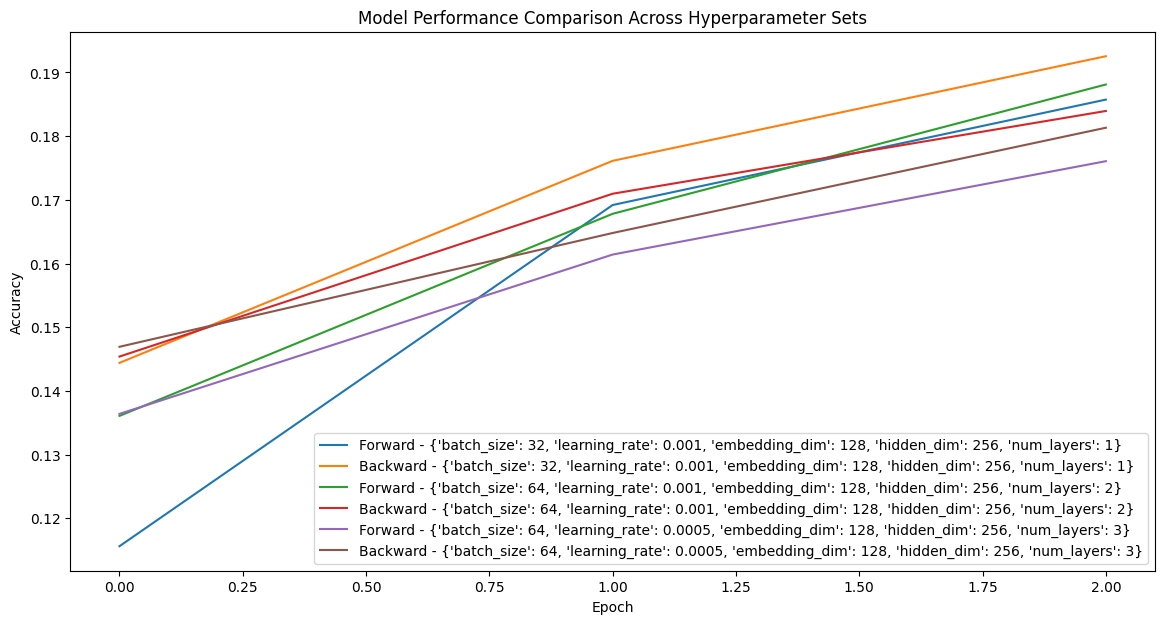

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

for param_set, metrics in experiment_results.items():
    plt.plot(metrics['Forward Accuracies'], label=f"Forward - {param_set}")
    plt.plot(metrics['Backward Accuracies'], label=f"Backward - {param_set}")

plt.title("Model Performance Comparison Across Hyperparameter Sets")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [10]:
from transformers import AutoTokenizer


tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


class Vocab:
    def __init__(self, tokenizer):
        self.vocab = tokenizer.get_vocab()  # Get the vocab dictionary from the tokenizer
        self.reverse_vocab = {v: k for k, v in self.vocab.items()}  # Reverse vocab for lookup by index


    def get(self, word):
        # Return the index of the word, or use the [UNK] token if the word is not in the vocab
        return self.vocab.get(word.lower(), self.vocab.get("[UNK]"))

    def lookup_token(self, index):
        # Return the word corresponding to the index, or [UNK] if the index is out of bounds
        return self.reverse_vocab.get(index, "[UNK]")


vocab = Vocab(tokenizer)


sample_sentence = ["The", "sun", "rises", "in", "the", "_____"]
blank_index = 5  # Position of the blank

# Convert sentence to token indices using vocab
indexed_sentence = [vocab.get(word) for word in sample_sentence]
print(indexed_sentence)


[1996, 3103, 9466, 1999, 1996, 100]


# Prediction Handling

In [34]:
import torch
import numpy as np
from collections import Counter
from torch.utils.data import DataLoader
from transformers import AutoTokenizer

# Load a tokenizer (adjust as needed, e.g., BERT or custom tokenizer)
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Ensure you're using a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to predict the missing word
def predict_missing_word(model, sentence, tokenizer, max_length):
    model.eval()
    with torch.no_grad():
        # Tokenize the input sentence and convert to tensor
        tokenized_sentence = tokenizer.encode(sentence, add_special_tokens=False)
        tokenized_sentence = torch.tensor(tokenized_sentence).unsqueeze(0).to(device)  # Shape: [1, seq_length]

        # Pad if needed
        if tokenized_sentence.shape[1] < max_length:
            padding_length = max_length - tokenized_sentence.shape[1]
            tokenized_sentence = torch.cat([tokenized_sentence, torch.zeros(1, padding_length).long().to(device)], dim=1)

        # Make prediction
        output = model(tokenized_sentence)
        predicted_token_index = torch.argmax(output, dim=-1).item()

        # Use tokenizer to get the word from the predicted index
        predicted_word = tokenizer.convert_ids_to_tokens(predicted_token_index)

        return predicted_word

# Sample sentences for testing
sample_sentences = [
    "The quick brown fox jumps over the lazy [MASK]",
    "Artificial intelligence is changing the [MASK]",
    "Deep learning has made [MASK] progress in various fields",


]


processed_data = ["The quick brown fox jumps over the lazy dog",
                  "Artificial intelligence is changing the world",
                  "Deep learning has made significant progress in various fields",
                  ]

# Calculate the maximum length of sample sentences
max_length = max([len(tokenizer.encode(sent, add_special_tokens=False)) for sent in sample_sentences])

# Test forward and backward models (assuming models are defined)
for sentence in sample_sentences:
    forward_prediction = predict_missing_word(forward_lstm_model, sentence, tokenizer, max_length)
    backward_prediction = predict_missing_word(backward_lstm_model, sentence, tokenizer, max_length)

    print(f"Original sentence: {sentence}")
    print(f"Forward prediction for [MASK]: {forward_prediction}")
    print(f"Backward prediction for [MASK]: {backward_prediction}")
    print()


Original sentence: The quick brown fox jumps over the lazy [MASK]
Forward prediction for [MASK]: the
Backward prediction for [MASK]: [UNK]

Original sentence: Artificial intelligence is changing the [MASK]
Forward prediction for [MASK]: of
Backward prediction for [MASK]: of

Original sentence: Deep learning has made [MASK] progress in various fields
Forward prediction for [MASK]: nearer
Backward prediction for [MASK]: [UNK]

